# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Imports

In [2]:
import progressbar
import pandas as pd
import numpy as np
import math
import json
import re
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Preview

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Data Cleaning

### Profile

In [6]:
profile.loc[profile.age > 98, 'age'] = np.nan
# profile.became_member_on = profile['became_member_on'].astype('datetime64[ns]')
profile.became_member_on = profile.became_member_on.astype('str')
profile.became_member_on = profile['became_member_on'].astype('datetime64[ns]') # , format = "%Y%m%d")

profile = profile.drop(profile[profile['gender'].isnull()].index)

profile = profile.drop(profile[profile['age'].isnull()].index)

profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

profile.head(5)

,gender,age,id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


### Transcript

In [7]:
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del ret[column]
    else:
        ret = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del ret[column]
    return ret

transcript = unpack(transcript,'value')

In [8]:
transcript.drop(['offer_id','reward'] , axis =1, inplace = True )

In [9]:
transcript.rename(columns={'offer id': 'offer_id'}, inplace=True)
transcript = transcript[transcript.person.isin(profile.id)]

In [10]:
transcript['time'] = transcript['time'] / 24.0

In [11]:
transcript.duplicated().sum()

2856

In [12]:
transcript.drop_duplicates(inplace=True)

In [13]:
transcript.reset_index(drop=True, inplace=True)

In [14]:
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,person,time,amount
11011,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11014,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11016,54890f68699049c2a04d415abc25e717,0.00,13.23
11024,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11025,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
269469,24f56b5e1849462093931b164eb803b5,29.75,22.64
269471,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
269472,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
269473,a00058cf10334a308c68e7631c529907,29.75,3.61


In [15]:
offers_df = transcript[transcript.event!='transaction'].copy()

# hot encode 
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)
offers_df.drop(columns=['event', 'amount'], inplace=True)

In [16]:
offers_df.head(5)

,person,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [17]:
offers_df.completed.value_counts()

0    116183
1     29525
Name: completed, dtype: int64

### Portfolio

In [18]:
portfolio['channels1'] = [','.join(map(str, l)) for l in portfolio['channels']]

In [19]:
dummy_channels = portfolio['channels1'].str.get_dummies(sep=",")
portfolio = pd.concat([portfolio, dummy_channels], axis=1)
dummy_offer = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio, dummy_offer], axis=1)
portfolio.drop(['channels','channels1','offer_type'], axis =1, inplace = True )
portfolio

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


# EDA

### Distribution of income

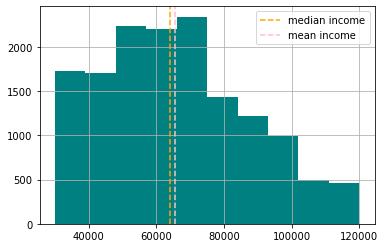

In [20]:
profile.income.hist(color = 'teal')
plt.axvline(profile.income.median(), color = 'orange', linestyle = '--', label = 'median income')
plt.axvline(profile.income.mean(), color = 'pink', linestyle = '--', label = 'mean income')
plt.legend()
plt.show()

We can see that the salary range of most of the customers lie between 50k to 70k.

### Income Distribution as a Function of Gender

Text(0.5, 0, 'Income($)')

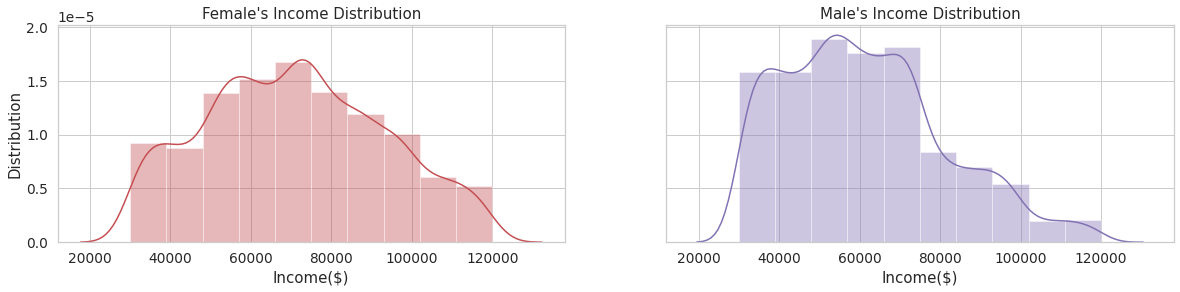

In [21]:
sns.set(style = 'whitegrid', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 2, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(profile[profile['gender'] == 0]['income'], bins = 10, color = palette[3]);
plt.title('Female\'s Income Distribution')
plt.xlabel('Income($)')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(profile[profile['gender'] == 1]['income'], bins = 10, color = palette[4]);
plt.title('Male\'s Income Distribution')
plt.xlabel('Income($)')

More number of females are positioned in highly paying jobs.

### Distribution of age

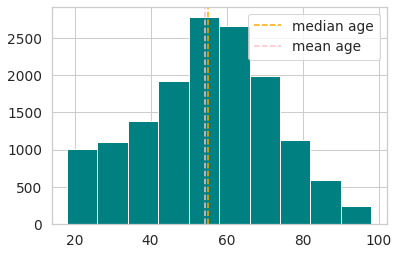

In [22]:
#age distribution
profile.age.hist(color = 'teal')
plt.axvline(profile.age.median(), color = 'orange', linestyle = '--', label = 'median age')
plt.axvline(profile.age.mean(), color = 'pink', linestyle = '--', label = 'mean age')
plt.legend()
plt.show()

### Age Distribution as a Function of Gender

Text(0.5, 0, 'Age')

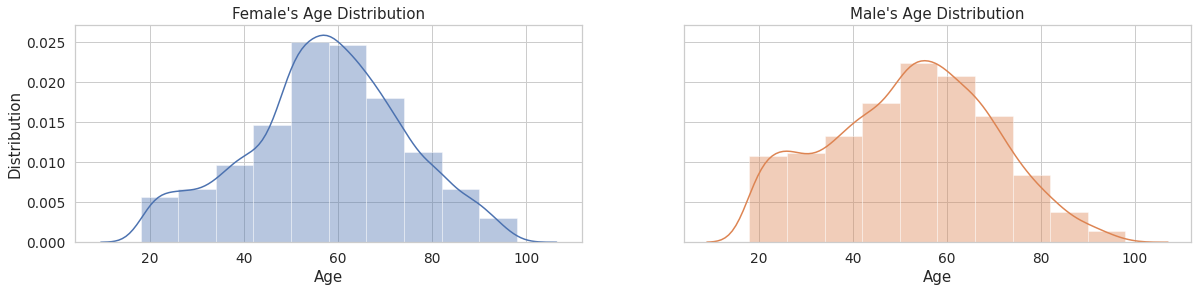

In [23]:
sns.set(style = 'whitegrid', font_scale = 1.25)
palette = sns.color_palette()

fig, ax = plt.subplots(figsize=(20,4), nrows = 1, ncols = 2, sharex = True, sharey = True)

plt.sca(ax[0])
sns.distplot(profile[profile['gender'] == 0]['age'], bins = 10, color = palette[0]);
plt.title('Female\'s Age Distribution')
plt.xlabel('Age')
plt.ylabel('Distribution')

plt.sca(ax[1])
sns.distplot(profile[profile['gender'] == 1]['age'], bins = 10, color = palette[1]);
plt.title('Male\'s Age Distribution')
plt.xlabel('Age')

People in their middle ages are more interested in Starbucks.

### Distribution of Genders Across Years

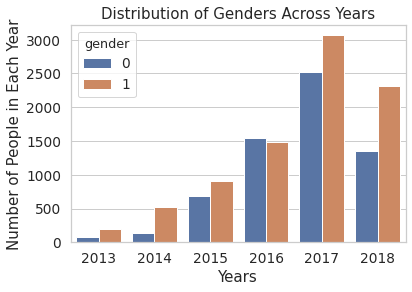

In [24]:
sns.countplot(data=profile, x='start_year', hue='gender');
plt.title('Distribution of Genders Across Years');
plt.xlabel('Years');
plt.ylabel('Number of People in Each Year');

2017 had the maximum turnout of both male(1) and female(0). Male turnout has been highest in all the years except 2016.

### Most common platform

In [25]:
dict = {}
dict['email'] = portfolio.email.sum()
dict['mobile'] = portfolio.mobile.sum()
dict['social'] = portfolio.social.sum()
dict['web'] = portfolio.web.sum()

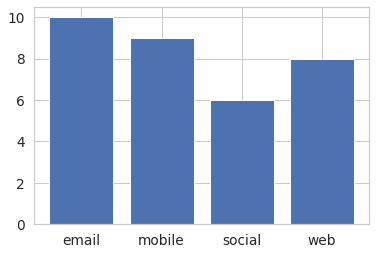

In [26]:
plt.bar(*zip(*dict.items()))
plt.show()

E-msil is the most common platform.

### Most commmon offer

In [27]:
dict_type = {}
dict_type['bogo'] = portfolio.bogo.sum()
dict_type['informational'] = portfolio.informational.sum()
dict_type['discount'] = portfolio.discount.sum()

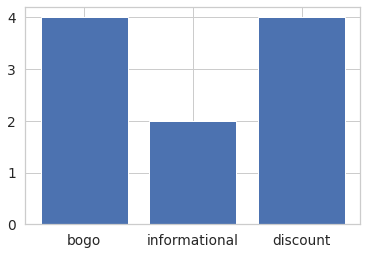

In [28]:
plt.bar(*zip(*dict_type.items()))
plt.show()

Discount and bogo are most common offer.

# Combine Datasets

In [29]:
def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['person'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['person']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['person']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [30]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:13:43] |##################################| (Time:  0:13:43) 


In [31]:
columns_list = ['time', 'offer_id', 'id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
data[columns_list]

,time,offer_id,id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1,0,...,1,1,0,1,2017-05-09,0,100000.0,75.0,2017,5
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0,0,...,1,1,1,0,2017-05-09,0,100000.0,75.0,2017,5
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1,0,...,1,1,1,0,2017-05-09,0,100000.0,75.0,2017,5
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1,0,...,1,1,1,1,2017-05-09,0,100000.0,75.0,2017,5
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0,1,...,1,1,0,1,2018-04-26,1,70000.0,68.0,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66397,24.0,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,34.04,0,10,7,2,0,1,...,1,1,0,1,2017-08-20,1,44000.0,59.0,2017,8
66398,24.0,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,19.92,0,0,3,0,0,0,...,1,1,1,0,2017-08-02,1,64000.0,44.0,2017,8
66399,24.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,28.42,0,5,7,5,1,0,...,1,1,0,1,2018-04-23,1,73000.0,61.0,2018,4
66400,24.0,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,75.84,1,7,7,3,0,1,...,1,1,1,1,2017-12-23,0,86000.0,52.0,2017,12


In [32]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])

data = data[column_ordering]
data = data.drop(columns=['time', 'customer_id', 'id', 'email', 'informational', 'became_member_on'])
data.head()

,offer_id,total_amount,offer_successful,reward,difficulty,duration,mobile,social,web,bogo,discount,gender,age,income,start_year,start_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,5,7,1,0,1,1,0,0,75.0,100000.0,2017,5
1,5a8bc65990b245e5a138643cd4eb9837,49.39,0,0,0,3,1,1,0,0,0,0,75.0,100000.0,2017,5
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,1,10,10,7,1,1,0,1,0,0,75.0,100000.0,2017,5
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,1,5,5,5,1,1,1,1,0,0,75.0,100000.0,2017,5
4,2906b810c7d4411798c6938adc9daaa5,0.00,0,2,10,7,1,0,1,0,1,1,68.0,70000.0,2018,4


# Model building

### Splitting data into test and train datasets

In [33]:
# factors/features that influence the label variable
features = data.drop(columns=['offer_successful'])

# label variable to predict
label = data.filter(['offer_successful'])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

# train-data: extract offer_id, total_amount and convert other features to float 
offer_id_train = X_train[:, 0]
total_amount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

# test-data: extract offer_id, total_amount and convert other features to float 
offer_id_test = X_test[:, 0]
total_amount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Evaluate naive predictor performance

In [34]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.473
Naive predictor f1-score: 0.642


### Logistic Regression model

In [35]:
scorer = make_scorer(fbeta_score, beta=0.5)

# initiating a logistic regression classifer object
lr_clf = LogisticRegression(random_state=42, solver='liblinear')

# construct a params dict to tune the model
grid_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.1, 0.01]}

lr_random = RandomizedSearchCV(
    estimator = lr_clf, param_distributions = grid_params, 
    scoring=scorer, n_iter = 6, cv = 3, verbose=2, 
    random_state=42, n_jobs = 3)

# fit train data to the model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   59.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(random_state=42,
                                                solver='liblinear'),
                   n_iter=6, n_jobs=3,
                   param_distributions={'C': [1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=2)

### Evaluate model performance

In [36]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [37]:
# evaluate logistic regression model's performance
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.699
LogisticRegression model f1-score: 0.696


(0.6988877175620146, 0.6955538153658749)

**Results**
We can see that f1 score and model accuracy of logistic regression is better than naive predictor.

Accuracy:
* Logistic Regression : 0.699
* Naive Predictor : 0.473

F1 score:
* Logistic Regression : 0.696
* Naive Predictor : 0.642

### Evaluate test data performance

In [38]:
evaluate_model_performance(lr_random, X_test, y_test)

RandomizedSearchCV model accuracy: 0.701
RandomizedSearchCV model f1-score: 0.696


(0.7011696199989961, 0.6956077107940891)

### Random forest classifier model

In [39]:
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   55.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  3.3min
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  6.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=3,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300]},
                   random_state=42, scoring=make_scorer(fbeta_score, beta=0.5),
                   verbose=2)

### Evaluate model performance

In [40]:
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)

RandomForestClassifier model accuracy: 0.848
RandomForestClassifier model f1-score: 0.840


(0.8482820937587401, 0.8399891087311672)

**Results**
We can see that f1 score and model accuracy of logistic regression is better than naive predictor.

Accuracy:
* Random Forest : 0.848
* Naive Predictor : 0.473

F1 score:
* Ramdom Forest : 0.840
* Naive Predictor : 0.642

### Evaluate test data performance

In [42]:
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.735
RandomForestClassifier model f1-score: 0.717


(0.7351036594548467, 0.7165798378000967)

# Conclusion

The goal was to predict whether a customer would use an offer. The problem was approached by cleaning and combining the profile, portfolio and transcript datasets. Then it was followed by constructing a naive model which assumed that all the offers were successful. The accuracy and the f1 score of the model were obtained. It was followed by comparing the performance of logistic regression and random forest models. The random forest model had best accuracy and f1 score of 0.848 & 0.840 respectively. The test data accuracy of 0.735 and f1 score of 0.717 shows that the random forest model that was constructed did not overfit the training data.

The availability of more features would have resulted in building a better random forest model that would have predicted an offers succcess rate. As more rows were eliminated due to Nan values and duplicates the model had less data to work with. The availability of more data would have resulted in better accuracy and f1 score. The data available on the customer should also be indepth to define each individual customer. The features of the customer would have helped in producing better classification model results.